# Concept Activation Vectors (CAVs) example on CIFAR data
### Peter Xenopoulos

In this workbook, we will go over how to use CAVs on some popular image data -- the CIFAR datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import keras
from keras.datasets import cifar100, cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

from cav.cav import *

np.random.seed(1996)

Using TensorFlow backend.


First we must import some images from CIFAR-10. We will import the _ships_ and the _dog_ images.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Keep airplanes (5) and ships (8) from CIFAR-10
ships = y_train == [8]
ship_indx = [i for i, x in enumerate(ships) if x]
x_train_class_one = x_train[ship_indx]
other = y_train == [2]
other_indx = [i for i, x in enumerate(other) if x]
x_train_class_two = x_train[other_indx]

x_train = np.append(x_train_class_one, x_train_class_two, axis = 0)
y_train = [1] * 5000
y_train = y_train + [0] * 5000

Below is an example of some of the images

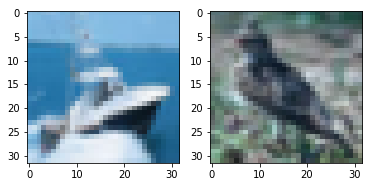

In [3]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[0])
axarr[1].imshow(x_train[7777])

Next, we must specify a _concept_. This is a certain idea we want to capture from our pictures. Let's say we are interested in the concept of the _sea_. Let's load in CIFAR-100 to get some pictures of the sea and some random counterexample, which we'll just make apples for ease of use.

In [4]:
(x_train_concept, y_train_concept), (x_test_concept, y_test_concept) = cifar100.load_data()

# keep sea (54) from CIFAR-100
concept = y_train_concept == [71]
indices = concept
indx_to_use = [i for i, x in enumerate(indices) if x]

x_train_concept = x_train_concept[indx_to_use]
y_train_concept = [1] * 500
y_train_concept = y_train_concept + [0] * 500

counterexamples = create_counterexamples(n = 500, height = 32, width = 32, channels = 3)
x_train_concept = np.append(x_train_concept, counterexamples, axis = 0)

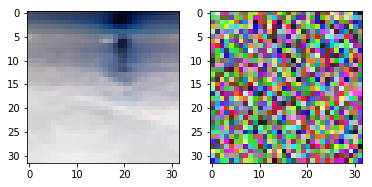

In [5]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train_concept[0])
axarr[1].imshow(x_train_concept[777])

Now, we must train our initial model. We do so below.

In [6]:
# Set parameters
batch_size = 32
epochs = 3

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# initiate optimizer
opt = keras.optimizers.Adam(lr=0.001)

# train the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/3
10000/10000 [==============================] - 29s 3ms/step - loss: 0.3651 - acc: 0.8345
Epoch 2/3
10000/10000 [==============================] - 29s 3ms/step - loss: 0.2411 - acc: 0.9041
Epoch 3/3
10000/10000 [==============================] - 29s 3ms/step - loss: 0.1939 - acc: 0.9246


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

First, we split our model on a given layer. We can see that the last convolution layer is layer 8, but in order for our method to work, we need to include the activations and pooling and flattening. So, we will split on layer 12. Then, we train a binary classifier on our concepts. This will produce our concept activation vector.

In [8]:
model_f, model_h = return_split_models(model, 12)
cav_vec = train_cav(model_f, x_train_concept, y_train_concept)

In [9]:
y_train_concept

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


Below we see the concept activation vector

In [10]:
cav_vec

array([[ 0.        ],
       [ 0.00052143],
       [ 0.        ],
       ...,
       [ 0.        ],
       [-0.00012095],
       [ 0.00011654]])

Now, for each original training example, we calculate the sensitivity to the concept using our `cav_vec`

In [11]:
sensitivities = conceptual_sensitivity(x_train, model_f, model_h, cav_vec)

In [12]:
sensitivities[0:4999]

array([[6.24233844e-05],
       [6.85494064e-05],
       [8.42133079e-04],
       ...,
       [1.74155387e-03],
       [1.11806593e-05],
       [1.35763677e-03]])

In [13]:
sensitivities[5000:]

array([[1.04927273e-05],
       [7.93217196e-03],
       [3.71445735e-04],
       ...,
       [6.07880196e-05],
       [3.64388072e-03],
       [4.25057372e-05]])

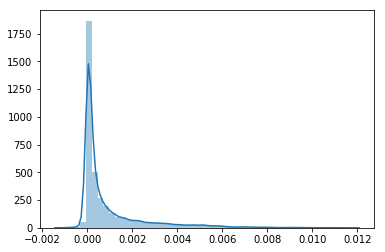

In [14]:
import seaborn as sns, numpy as np
sns.distplot(sensitivities)
plt.legend()

In [15]:
np.sum(sensitivities[0:4999] < 0)/5000

0.002

In [16]:
np.sum(sensitivities[5000:] < 0)/5000

0.0522